<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/DL_torchvsion_DCGAN_car_ex5_multiCarGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 現場で使える！　PyTorchPyTorch開発入門


##翔泳社

DCGAN

## 1.1 Google Drive をマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


# データ生成

no_imagだけ同じ画像をコピーする。そのうち、１バッチに1枚だけ別の画像を作っておく。

In [ ]:
  !pwd
  !ls -al bkcar_c
  

/content/drive/My Drive/Colab Notebooks/yolo_train
total 87
-rw------- 1 root root 13537 Nov  3 10:26 Audi_A3_2015_c.jpg
-rw------- 1 root root 14719 Nov  3 10:27 Audi_A3_2016_c.jpg
-rw------- 1 root root 14665 Nov  3 10:25 Audi_A3_c.jpg
-rw------- 1 root root 14371 Nov  3 10:28 Audi_A4_2011_c.jpg
-rw------- 1 root root 15834 Nov  3 10:28 Audi_A4_2014_c.jpg
-rw------- 1 root root 14619 Nov  3 10:29 Audi_A5_2010_AWD_c.jpg


In [ ]:
!rm pspnet_car_data/jpg/*

In [ ]:
!rm -R acar/*

作為的にデータを生成

In [ ]:
import shutil
import random

no_img = 512
no_batch = 16


filename = "Audi_A3_2015_c"
src = "bkcar_c/" + filename + ".jpg"

for i in range(no_img):
  copy = "pspnet_car_data/jpg/Audi_c" + str(i) + ".jpg"
  shutil.copyfile(src,copy)

filename = "Audi_A3_2016_c"
src = "bkcar_c/" + filename + ".jpg"

print(int(no_img/no_batch))

for i in range(int(no_img/no_batch)):
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch+1) + ".jpg"
  shutil.copyfile(src,copy)

filename = "Audi_A3_c"
src = "bkcar_c/" + filename + ".jpg"

print(int(no_img/no_batch))

for i in range(int(no_img/no_batch)):
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch+2) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch+3) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch+4) + ".jpg"
  shutil.copyfile(src,copy)

filename = "Audi_A4_2011_c"
src = "bkcar_c/" + filename + ".jpg"

for i in range(int(no_img/no_batch)):
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch + 5) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch + 6) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch + 7) + ".jpg"
  shutil.copyfile(src,copy)

filename = "Audi_A4_2014_c"
src = "bkcar_c/" + filename + ".jpg"

for i in range(int(no_img/no_batch)):
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch + 8) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch + 9) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/Audi_c" + str(i * no_batch + 10) + ".jpg"
  shutil.copyfile(src,copy)

filename = "Audi_A5_2010_AWD_c"
src = "bkcar_c/" + filename + ".jpg"

for i in range(int(no_img/no_batch*2)):
  rand = random.uniform(1, no_img)
  rand = int(rand)
  copy = "pspnet_car_data/jpg/Audi_c" + str(rand) + ".jpg"
  shutil.copyfile(src,copy)



32
32


## 1.2 モジュール読み込み

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time

import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import copy

#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import save_image

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

PyTorch Version:  1.9.0+cu111
Torchvision Version:  0.10.0+cu111
Setup complete. Using torch 1.9.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


device(type='cuda', index=0)

##DCGANによる画像生成

Stanfrod Cars Datasetから選別した画像をセマンティックセグメンテーションにて車だけを抜き出し、背景を白色にした画像を用いる。

用いる画像ファイルの数を確認。

In [4]:

DIR = 'pspnet_car_data/jpg/'

print(sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR)))

512


In [5]:
#img_data = ImageFolder("./stanford-car",
img_data = ImageFolder("./pspnet_car_data",
    transform=transforms.Compose([
        transforms.Resize(130),
#        transforms.Resize(140),
#        transforms.Resize(160),
        transforms.CenterCrop(128),
        transforms.ToTensor()
]))

#batch_size = 8
batch_size = 16
#batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

データの確認

In [ ]:
batch_iterator = iter(img_loader)
imges = next(batch_iterator)
print(imges[0].size())

torch.Size([16, 3, 128, 128])


画像生成モデル

In [6]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8,   
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 8, 
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        return out

識別モデル

In [7]:
ndf = 128
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

訓練関数の作成

In [8]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [12]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
#    for real_img, _ in loader:
    for real_img, _ in tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)

        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)

        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()

    return mean(log_loss_g), mean(log_loss_d)

訓練開始

In [14]:

import datetime

for epoch in range(300):
    loss_g, loss_d = train_dcgan(g, d, opt_g, opt_d, img_loader)
    print("{} Epoch {}, {}, {} ".format(datetime.datetime.now(), epoch, loss_g, loss_d))
    # 10回の繰り返しごとに学習結果を保存する
    if epoch % 10 == 0:
        # パラメータの保存
        #torch.save(
        #    g.state_dict(),
         #   "cars_train/g_{:03d}.prm".format(epoch),
          #  pickle_protocol=4)
        #torch.save(
         #   d.state_dict(),
          #  "cars_train/d_{:03d}.prm".format(epoch),
           # pickle_protocol=4)
        # モニタリング用のzから生成した画像を保存
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "./pspnet_car_data/no7_blkcar_b16-{:03d}.jpg".format(epoch))

100%|██████████| 32/32 [00:06<00:00,  4.82it/s]


2021-11-05 09:50:12.127233 Epoch 0, 6.528458282351494, 0.003744443874893477 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 09:50:18.646501 Epoch 1, 6.65972962975502, 0.0026215830876026303 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:50:25.089019 Epoch 2, 6.954734846949577, 0.002271871784614632 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:50:31.500313 Epoch 3, 7.222712859511375, 0.00167791648345883 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:50:37.913441 Epoch 4, 7.517417415976524, 0.001231967709827586 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:50:44.330248 Epoch 5, 7.261259838938713, 0.00161260428467358 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:50:50.745709 Epoch 6, 7.257024452090263, 0.0013606834581878502 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:50:57.189325 Epoch 7, 7.398199066519737, 0.0012567703906825045 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:51:03.634965 Epoch 8, 7.371029824018478, 0.0012897911274194485 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:51:10.070970 Epoch 9, 6.919670030474663, 0.0016848974955792073 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:51:16.490288 Epoch 10, 7.143945574760437, 0.0015216249612421962 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:51:23.006242 Epoch 11, 7.258461982011795, 0.0011397657362977043 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:51:29.450282 Epoch 12, 7.192911371588707, 0.0014508629956253571 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 09:51:35.959645 Epoch 13, 7.240617871284485, 0.0011496622155391378 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:51:42.400445 Epoch 14, 7.032924920320511, 0.0015608069734298624 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:51:48.837727 Epoch 15, 7.046245440840721, 0.0014298905589384958 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:51:55.258259 Epoch 16, 6.708994969725609, 0.001978450673050247 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 09:52:01.755851 Epoch 17, 6.699452295899391, 0.002777878016786417 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:52:08.169718 Epoch 18, 7.101614639163017, 0.0019487189274514094 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:52:14.583363 Epoch 19, 7.675318896770477, 0.0005396327123889932 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:52:21.017240 Epoch 20, 7.828507915139198, 0.0005819963862450095 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:52:27.496281 Epoch 21, 7.946137771010399, 0.0005200388113735244 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 09:52:33.978652 Epoch 22, 8.103656694293022, 0.0005445389101623732 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 09:52:40.383733 Epoch 23, 8.033495366573334, 0.000607252173267625 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:52:46.827617 Epoch 24, 8.041494369506836, 0.0004507025596467429 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:52:53.245476 Epoch 25, 8.060991048812866, 0.0005762258124377695 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:52:59.689586 Epoch 26, 7.976394817233086, 0.0005221583255661244 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 09:53:06.090168 Epoch 27, 7.575485214591026, 0.0008864987112247036 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:53:12.516990 Epoch 28, 7.890722438693047, 0.0006445948147302261 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:53:18.940553 Epoch 29, 7.728452920913696, 0.0011177341712027555 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:53:25.374918 Epoch 30, 7.803639799356461, 0.0004867179504799424 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:53:31.893112 Epoch 31, 8.190591126680374, 0.0004090369029654539 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 09:53:38.358692 Epoch 32, 8.338057100772858, 0.0003285876182417269 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 09:53:44.854571 Epoch 33, 8.399534776806831, 0.00034851466580221313 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:53:51.262169 Epoch 34, 8.550632894039154, 0.0003716779579008289 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:53:57.698213 Epoch 35, 8.734397619962692, 0.00033752048648238997 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:54:04.109061 Epoch 36, 8.624209761619568, 0.00028112501559007796 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:54:10.535244 Epoch 37, 8.393464893102646, 0.000331923757585173 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:54:16.950930 Epoch 38, 8.222461327910423, 0.000388750241654634 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:54:23.407038 Epoch 39, 8.157406851649284, 0.0003950850914407056 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:54:29.826006 Epoch 40, 8.137166529893875, 0.00047952786098903744 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:54:36.310995 Epoch 41, 8.038755387067795, 0.000645777706267836 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 09:54:42.784452 Epoch 42, 8.11160796880722, 0.0008331099065799208 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 09:54:49.266979 Epoch 43, 8.492423951625824, 0.00026748206983029377 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:54:55.718937 Epoch 44, 8.419866859912872, 0.0003294777993687603 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 09:55:02.132123 Epoch 45, 8.51547947525978, 0.0002886064576159697 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:55:08.579029 Epoch 46, 8.22586975991726, 0.000962809092925454 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:55:15.017435 Epoch 47, 8.834621101617813, 0.00016754594093981723 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 09:55:21.418931 Epoch 48, 8.964647382497787, 0.00017988115837397345 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:55:27.843363 Epoch 49, 8.946572840213776, 0.0002011342271543981 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:55:34.281530 Epoch 50, 8.742569237947464, 0.00022398393321054755 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:55:40.789612 Epoch 51, 8.86355471611023, 0.0002682347642348759 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 09:55:47.257323 Epoch 52, 9.201308399438858, 0.00021242604793769715 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 09:55:53.666059 Epoch 53, 9.301034688949585, 0.00023770709458403871 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 09:56:00.070923 Epoch 54, 9.334812313318253, 0.0001600276216322527 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:56:06.492726 Epoch 55, 9.453378707170486, 0.0001344631605206814 


100%|██████████| 32/32 [00:06<00:00,  5.03it/s]


2021-11-05 09:56:12.874687 Epoch 56, 9.418816596269608, 0.00015419034048136382 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:56:19.338100 Epoch 57, 9.443307757377625, 0.0001662530435169174 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:56:25.761940 Epoch 58, 9.433775931596756, 0.00015431689735123655 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:56:32.198274 Epoch 59, 9.316322833299637, 0.00017628824048188108 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:56:38.637109 Epoch 60, 9.03863725066185, 0.00023111616837923066 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:56:45.148965 Epoch 61, 9.146000146865845, 0.00024416884912170644 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:56:51.571974 Epoch 62, 9.23509231209755, 0.00015990119641173806 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:56:57.995149 Epoch 63, 9.35722342133522, 0.00016471852222821326 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:57:04.425110 Epoch 64, 9.618767499923706, 0.00012657893262257858 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:57:10.844841 Epoch 65, 9.759365141391754, 0.00011592764337819972 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:57:17.265239 Epoch 66, 9.918588548898697, 0.00010253899370127328 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:57:23.675096 Epoch 67, 9.997164219617844, 9.356350722100615e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:57:30.122048 Epoch 68, 10.030737400054932, 8.630273578091874e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:57:36.545137 Epoch 69, 10.14391440153122, 8.796880752015568e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:57:42.964753 Epoch 70, 10.17143177986145, 7.055887556361995e-05 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 09:57:49.482292 Epoch 71, 9.831186980009079, 8.799598100495132e-05 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:57:55.911281 Epoch 72, 9.70454928278923, 0.00010379121192727325 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:58:02.371082 Epoch 73, 9.93379059433937, 9.045148181030527e-05 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 09:58:08.892575 Epoch 74, 10.201881349086761, 6.250274861940852e-05 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 09:58:15.288455 Epoch 75, 10.272649377584457, 8.424070574619691e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:58:21.708409 Epoch 76, 10.368475943803787, 5.6492123917450954e-05 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:58:28.131263 Epoch 77, 10.52016544342041, 5.399103793024551e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:58:34.548225 Epoch 78, 10.583309829235077, 4.583888380693679e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 09:58:40.991078 Epoch 79, 10.745730757713318, 4.12792966244524e-05 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 09:58:47.397031 Epoch 80, 10.817633390426636, 4.305910300672622e-05 


100%|██████████| 32/32 [00:06<00:00,  5.02it/s]


2021-11-05 09:58:53.846945 Epoch 81, 10.83446815609932, 4.952574835215273e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:59:00.276078 Epoch 82, 10.891536355018616, 3.714976440960527e-05 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 09:59:06.680254 Epoch 83, 11.043896824121475, 3.0892096390289225e-05 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 09:59:13.108657 Epoch 84, 11.105715930461884, 3.227121638360586e-05 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 09:59:19.565907 Epoch 85, 11.189558565616608, 3.052767661415601e-05 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 09:59:26.061333 Epoch 86, 11.221893459558487, 2.6877708819483814e-05 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 09:59:32.523279 Epoch 87, 11.303129464387894, 2.8359911738107257e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:59:38.930537 Epoch 88, 11.320417493581772, 2.4082164060246214e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 09:59:45.359914 Epoch 89, 11.483725160360336, 2.5994635763026963e-05 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 09:59:51.868560 Epoch 90, 11.456005245447159, 2.6393303414806724e-05 


100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


2021-11-05 09:59:58.448292 Epoch 91, 11.527301728725433, 2.0676588519563666e-05 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:00:04.961166 Epoch 92, 11.511565953493118, 2.4893119018543075e-05 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:00:11.430797 Epoch 93, 11.521686971187592, 1.8422116795591137e-05 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:00:17.911396 Epoch 94, 11.442515254020691, 2.1165074286955132e-05 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:00:24.418592 Epoch 95, 11.449778139591217, 2.0839567469010944e-05 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:00:30.932209 Epoch 96, 11.276063054800034, 2.2668884213317142e-05 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:00:37.353780 Epoch 97, 11.029691904783249, 3.128482808278932e-05 


100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


2021-11-05 10:00:43.887098 Epoch 98, 10.883800685405731, 2.7718898934381286e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:00:50.330742 Epoch 99, 10.893329381942749, 3.192082905911775e-05 


100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


2021-11-05 10:00:56.870746 Epoch 100, 10.81969889998436, 3.383495192110786e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:01:03.369052 Epoch 101, 10.83592426776886, 3.573744402274315e-05 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:01:09.890731 Epoch 102, 10.918969631195068, 2.8473461924249932e-05 


100%|██████████| 32/32 [00:06<00:00,  5.02it/s]


2021-11-05 10:01:16.283005 Epoch 103, 11.060579031705856, 2.685417467773732e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:01:22.722306 Epoch 104, 11.226199716329575, 2.345699897432496e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:01:29.135893 Epoch 105, 11.331925004720688, 2.1798314008947273e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:01:35.578548 Epoch 106, 11.433117717504501, 2.060575562268241e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:01:41.996829 Epoch 107, 11.547564923763275, 1.7930141410715805e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:01:48.431580 Epoch 108, 11.644333630800247, 2.1083344137196036e-05 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:01:54.895054 Epoch 109, 11.745811879634857, 1.7267048832536602e-05 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:02:01.362413 Epoch 110, 11.751487284898758, 2.026609175231897e-05 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:02:07.887352 Epoch 111, 11.954451084136963, 1.3324593851393729e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:02:14.334062 Epoch 112, 11.909443974494934, 1.3155796153796473e-05 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:02:20.789647 Epoch 113, 11.986478805541992, 1.2877325502813619e-05 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:02:27.274262 Epoch 114, 12.026484280824661, 1.2344609530146045e-05 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 10:02:33.679134 Epoch 115, 12.019500941038132, 1.257626151129898e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:02:40.125005 Epoch 116, 12.056782513856888, 1.1399798154343443e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:02:46.561704 Epoch 117, 12.0702383518219, 2.1192930802271803e-05 


100%|██████████| 32/32 [00:06<00:00,  5.03it/s]


2021-11-05 10:02:52.942645 Epoch 118, 12.00644063949585, 1.4830822095746043e-05 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:02:59.420930 Epoch 119, 10.862067252397537, 0.00027418766870823674 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:03:05.920943 Epoch 120, 11.520178258419037, 1.2189761122272103e-05 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:03:12.480665 Epoch 121, 11.838247567415237, 8.796529186838598e-06 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:03:18.958012 Epoch 122, 11.94360065460205, 8.085703314009152e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:03:25.394834 Epoch 123, 12.041731029748917, 7.662416678044792e-06 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 10:03:31.801747 Epoch 124, 11.698810338973999, 9.87848245870282e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:03:38.238586 Epoch 125, 11.55882054567337, 1.1156009904311759e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:03:44.670158 Epoch 126, 11.557896196842194, 1.1444020614703732e-05 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:03:51.083949 Epoch 127, 11.608407825231552, 1.1919666974335996e-05 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:03:57.512793 Epoch 128, 11.816446483135223, 8.993735704621031e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:04:03.950529 Epoch 129, 11.771245658397675, 9.471734102817209e-06 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:04:10.366651 Epoch 130, 11.845806270837784, 8.772549193736268e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:04:16.871955 Epoch 131, 11.944364815950394, 1.0176876699574677e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:04:23.316933 Epoch 132, 12.095896601676941, 7.003053951848415e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:04:29.748330 Epoch 133, 12.15276962518692, 7.010271197316342e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:04:36.183751 Epoch 134, 12.260263711214066, 6.0710388254392456e-06 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 10:04:42.590931 Epoch 135, 12.268153339624405, 6.309922277125679e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:04:49.037045 Epoch 136, 12.383312791585922, 5.287569265988168e-06 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:04:55.556842 Epoch 137, 12.448146611452103, 5.244030141682288e-06 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:05:02.007456 Epoch 138, 12.442867279052734, 7.11400539898932e-06 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:05:08.525390 Epoch 139, 12.500534504652023, 5.021446007447139e-06 


100%|██████████| 32/32 [00:06<00:00,  4.89it/s]


2021-11-05 10:05:15.079626 Epoch 140, 12.546152919530869, 4.6605601866644975e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:05:21.590717 Epoch 141, 12.501362353563309, 4.907591900860098e-06 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:05:28.097495 Epoch 142, 12.562775373458862, 5.151595210861615e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:05:34.541120 Epoch 143, 12.562056511640549, 4.836579421407805e-06 


100%|██████████| 32/32 [00:06<00:00,  5.02it/s]


2021-11-05 10:05:40.935955 Epoch 144, 12.589028716087341, 4.60258579693118e-06 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:05:47.427426 Epoch 145, 12.61518731713295, 4.505728874448778e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:05:53.870318 Epoch 146, 12.67053136229515, 4.746705144498264e-06 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:06:00.348919 Epoch 147, 12.557237029075623, 4.872202573835693e-06 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:06:06.849455 Epoch 148, 12.532800614833832, 4.865683578714197e-06 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:06:13.301961 Epoch 149, 12.507049292325974, 5.080119684919282e-06 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:06:19.769311 Epoch 150, 12.45048701763153, 5.340190249114585e-06 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:06:26.346221 Epoch 151, 12.47557383775711, 8.545388901382012e-06 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:06:32.880996 Epoch 152, 12.443242281675339, 5.4889666074586785e-06 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:06:39.351556 Epoch 153, 12.381876140832901, 5.542284725379432e-06 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:06:45.858486 Epoch 154, 12.354303032159805, 5.6295965507047185e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:06:52.297499 Epoch 155, 12.383746445178986, 5.556022429686891e-06 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:06:58.715243 Epoch 156, 12.28129455447197, 1.385875770409939e-05 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:07:05.160895 Epoch 157, 12.38603162765503, 6.625157574546847e-06 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:07:11.678959 Epoch 158, 12.40857109427452, 5.353228573312663e-06 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:07:18.106980 Epoch 159, 12.578803837299347, 4.562772140559446e-06 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 10:07:24.515523 Epoch 160, 12.723002970218658, 4.242631881368197e-06 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:07:31.053636 Epoch 161, 12.669333279132843, 4.22004766420514e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:07:37.496647 Epoch 162, 12.69950720667839, 6.670740063441372e-06 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:07:44.001684 Epoch 163, 12.637888729572296, 4.59676630271133e-06 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:07:50.487214 Epoch 164, 12.63570100069046, 1.0287596346358896e-05 


100%|██████████| 32/32 [00:06<00:00,  4.90it/s]


2021-11-05 10:07:57.047454 Epoch 165, 12.537682950496674, 4.8959520029256964e-06 


100%|██████████| 32/32 [00:06<00:00,  4.90it/s]


2021-11-05 10:08:03.589301 Epoch 166, 12.692207902669907, 4.283144193095723e-06 


100%|██████████| 32/32 [00:06<00:00,  4.90it/s]


2021-11-05 10:08:10.128058 Epoch 167, 12.78077256679535, 5.135761377061954e-06 


100%|██████████| 32/32 [00:06<00:00,  4.85it/s]


2021-11-05 10:08:16.749312 Epoch 168, 12.913563549518585, 3.7236539860430184e-06 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:08:23.244730 Epoch 169, 12.904663771390915, 3.6065411492813837e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:08:29.686107 Epoch 170, 13.059912979602814, 3.3341299108258227e-06 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:08:36.225501 Epoch 171, 13.068292528390884, 3.7273791519965016e-06 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:08:42.717614 Epoch 172, 13.188214927911758, 3.1227203791672764e-06 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:08:49.166658 Epoch 173, 12.93082481622696, 4.024703358140869e-06 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:08:55.683908 Epoch 174, 12.939058095216751, 4.249382669740953e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:09:02.108653 Epoch 175, 13.123427540063858, 3.5581090287450934e-06 


100%|██████████| 32/32 [00:06<00:00,  5.02it/s]


2021-11-05 10:09:08.512662 Epoch 176, 13.243793725967407, 2.877317918148492e-06 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:09:14.999260 Epoch 177, 13.273986756801605, 3.0684701926020352e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:09:21.457503 Epoch 178, 13.475059539079666, 2.3459996398855765e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:09:27.894979 Epoch 179, 13.542398422956467, 2.4691663327303104e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:09:34.320919 Epoch 180, 13.558681786060333, 2.472193337155204e-06 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:09:40.838043 Epoch 181, 13.588461369276047, 2.9317968284203744e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:09:47.282450 Epoch 182, 13.527500063180923, 2.5548480984127764e-06 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:09:53.707328 Epoch 183, 13.553797513246536, 2.614452402127654e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:10:00.149289 Epoch 184, 13.515556365251541, 2.791402671675769e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:10:06.596059 Epoch 185, 13.507580369710922, 2.6244636188721415e-06 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:10:13.099765 Epoch 186, 13.533939182758331, 2.81398778056996e-06 


100%|██████████| 32/32 [00:06<00:00,  4.90it/s]


2021-11-05 10:10:19.655805 Epoch 187, 13.553800910711288, 2.675685859543364e-06 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:10:26.142219 Epoch 188, 13.540024667978287, 1.133483270265856e-05 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:10:32.581541 Epoch 189, 13.448789894580841, 2.3806908693302375e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:10:38.999567 Epoch 190, 13.499523043632507, 2.2998986182187764e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:10:45.492070 Epoch 191, 13.602793484926224, 2.200247678274536e-06 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:10:51.919612 Epoch 192, 13.63145861029625, 2.6996649413746354e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:10:58.366755 Epoch 193, 13.671588033437729, 2.0679998939954203e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:11:04.794473 Epoch 194, 13.706767946481705, 1.920851133263568e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:11:11.239148 Epoch 195, 13.708449095487595, 1.725972438748613e-06 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:11:17.708038 Epoch 196, 13.751040488481522, 1.7117697552748723e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:11:24.145618 Epoch 197, 13.79370704293251, 1.7750996050835965e-06 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:11:30.641797 Epoch 198, 13.869269460439682, 1.8544943642950784e-06 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:11:37.116930 Epoch 199, 13.916915714740753, 1.5951218266252454e-06 


100%|██████████| 32/32 [00:06<00:00,  4.90it/s]


2021-11-05 10:11:43.663072 Epoch 200, 13.977874666452408, 1.7993135408289618e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:11:50.146237 Epoch 201, 14.01950427889824, 1.6475078190580916e-06 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:11:56.622720 Epoch 202, 14.110648155212402, 1.9206167607421776e-06 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:12:03.110991 Epoch 203, 14.129046469926834, 1.479870679332862e-06 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:12:09.617115 Epoch 204, 14.189698427915573, 1.335981535177666e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:12:16.056796 Epoch 205, 14.183858215808868, 1.9741626413605218e-06 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:12:22.469123 Epoch 206, 14.194331586360931, 1.2943049139124696e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:12:28.908678 Epoch 207, 14.140403628349304, 1.6132820501724154e-06 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:12:35.420005 Epoch 208, 14.112290143966675, 1.523642524148272e-06 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:12:41.878331 Epoch 209, 14.107076644897461, 1.4142124822313917e-06 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:12:48.375762 Epoch 210, 14.139968186616898, 1.4540263588713742e-06 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:12:54.904108 Epoch 211, 14.142684549093246, 1.5005916012000853e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:13:01.357747 Epoch 212, 14.108000576496124, 1.8377277655190483e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:13:07.783505 Epoch 213, 14.127394527196884, 1.2561207558547949e-06 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:13:14.264703 Epoch 214, 14.11002904176712, 1.6391262196435719e-06 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:13:20.745085 Epoch 215, 14.138719737529755, 1.2584490480804789e-06 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:13:27.219364 Epoch 216, 14.168608099222183, 1.3282980990680926e-06 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:13:33.700097 Epoch 217, 14.131731808185577, 1.3567034535810762e-06 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:13:40.181989 Epoch 218, 14.094963818788528, 1.43283840614572e-06 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:13:46.697427 Epoch 219, 14.095653295516968, 1.427250914787237e-06 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:13:53.188043 Epoch 220, 14.08337464928627, 1.482431203569945e-06 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:13:59.755546 Epoch 221, 14.129032105207443, 1.3839443706586962e-06 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:14:06.274256 Epoch 222, 14.13817474246025, 1.181382204507031e-06 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:14:12.721574 Epoch 223, 14.133480906486511, 1.3692762923511737e-06 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:14:19.169864 Epoch 224, 14.149391204118729, 1.3899980118026178e-06 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:14:25.648785 Epoch 225, 14.121233105659485, 1.3126984121925034e-06 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:14:32.077952 Epoch 226, 14.10453000664711, 2.8991586287219206e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:14:38.517277 Epoch 227, 14.091318100690842, 1.692210268799954e-06 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:14:44.940698 Epoch 228, 14.097486346960068, 1.1953520075991264e-06 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:14:51.354729 Epoch 229, 14.084848314523697, 1.3040838062750026e-06 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:14:57.802275 Epoch 230, 14.04655447602272, 1.345294769805605e-06 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:15:04.298229 Epoch 231, 14.043466329574585, 1.4509993135902732e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:15:10.738503 Epoch 232, 13.995344132184982, 1.3001257208600236e-06 


100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


2021-11-05 10:15:17.265269 Epoch 233, 13.906364649534225, 1.418403559938497e-06 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:15:23.701520 Epoch 234, 13.703444957733154, 1.6607799295798031e-06 


100%|██████████| 32/32 [00:06<00:00,  4.89it/s]


2021-11-05 10:15:30.273871 Epoch 235, 13.37540540099144, 2.173006521388743e-06 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:15:36.750590 Epoch 236, 13.028394728899002, 2.962300740705359e-06 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 10:15:43.156369 Epoch 237, 12.575963348150253, 4.302236540354443e-06 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:15:49.589530 Epoch 238, 12.223264425992966, 6.600264157441416e-06 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:15:56.118895 Epoch 239, 12.04731297492981, 1.088857024456047e-05 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:16:02.581968 Epoch 240, 12.193095266819, 7.784898500062809e-06 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:16:09.091767 Epoch 241, 11.995726883411407, 1.0734370690101969e-05 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:16:15.595674 Epoch 242, 11.9986911714077, 1.2413259000254584e-05 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:16:22.046966 Epoch 243, 11.837088227272034, 1.2668013653183152e-05 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:16:28.539410 Epoch 244, 11.49549013376236, 2.126085061604499e-05 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:16:35.039445 Epoch 245, 11.50235304236412, 1.8593942627376236e-05 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:16:41.514927 Epoch 246, 10.495335221290588, 8.870613021372264e-05 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:16:48.018179 Epoch 247, 11.117375671863556, 3.001184583695249e-05 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:16:54.546333 Epoch 248, 10.871175020933151, 4.491754549462712e-05 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:17:01.070142 Epoch 249, 12.862371447030455, 1.1138499192398967 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:17:07.489716 Epoch 250, 7.1558668948709965, 0.05911815007959831 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:17:14.029978 Epoch 251, 4.373479947447777, 0.01938129226618912 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:17:20.547042 Epoch 252, 5.1574888080358505, 0.009820127204875462 


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


2021-11-05 10:17:26.951425 Epoch 253, 7.01675895601511, 0.026138780796827632 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:17:33.486862 Epoch 254, 6.458869144320488, 0.0287017129189735 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:17:39.906844 Epoch 255, 9.672811105847359, 0.0011317544758639997 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:17:46.354694 Epoch 256, 6.28487890958786, 0.0026391257015347946 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


2021-11-05 10:17:52.791241 Epoch 257, 6.561766982078552, 0.0026799162551469635 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:17:59.306391 Epoch 258, 6.1841976046562195, 0.0063133369403658435 


100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


2021-11-05 10:18:05.834209 Epoch 259, 6.712319239974022, 0.0020630070321203675 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:18:12.340304 Epoch 260, 6.8639001697301865, 0.002054856377071701 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:18:18.875889 Epoch 261, 7.412220776081085, 0.001291730101002031 


100%|██████████| 32/32 [00:06<00:00,  4.89it/s]


2021-11-05 10:18:25.452809 Epoch 262, 6.484856158494949, 0.0030902322941983584 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:18:31.905575 Epoch 263, 6.571068346500397, 0.002904173630668083 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:18:38.430855 Epoch 264, 7.094336152076721, 0.0018089637815137394 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


2021-11-05 10:18:44.853869 Epoch 265, 7.265311270952225, 0.001373212895487086 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:18:51.323893 Epoch 266, 7.671902298927307, 0.0075683852087422565 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:18:57.829579 Epoch 267, 6.808327853679657, 0.0032477031090820674 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:19:04.353109 Epoch 268, 7.174348071217537, 0.0009035547227540519 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:19:10.835428 Epoch 269, 7.521300882101059, 0.0008148891774908407 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:19:17.296407 Epoch 270, 7.448998838663101, 0.0010563895466475515 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:19:23.825457 Epoch 271, 7.174839451909065, 0.0016446327326775645 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:19:30.299104 Epoch 272, 7.019227370619774, 0.0024614570847916184 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:19:36.780146 Epoch 273, 7.2762975841760635, 0.0012074517508153804 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:19:43.292046 Epoch 274, 7.188129678368568, 0.0018455486242601182 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:19:49.813599 Epoch 275, 7.687986493110657, 0.0008431478145212168 


100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


2021-11-05 10:19:56.349324 Epoch 276, 7.759314104914665, 0.0010087527107316419 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:20:02.816524 Epoch 277, 8.238014191389084, 0.0005752972547270474 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:20:09.306625 Epoch 278, 8.35021585226059, 0.0005782601365353912 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:20:15.821286 Epoch 279, 8.47126218676567, 0.00042918382769130403 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:20:22.330331 Epoch 280, 8.461361438035965, 0.0005728858868678799 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


2021-11-05 10:20:28.858447 Epoch 281, 8.812687635421753, 0.00033961371264012996 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:20:35.374706 Epoch 282, 8.69478490948677, 0.0004272844421393529 


100%|██████████| 32/32 [00:06<00:00,  4.89it/s]


2021-11-05 10:20:41.945134 Epoch 283, 8.908959448337555, 0.0003931001006094448 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:20:48.433010 Epoch 284, 8.876800864934921, 0.00032401878024757025 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:20:54.888482 Epoch 285, 8.93719631433487, 0.00028805868760173325 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:21:01.395147 Epoch 286, 9.178911954164505, 0.00022298912926999037 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


2021-11-05 10:21:07.916866 Epoch 287, 9.105295777320862, 0.00027726630150937126 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


2021-11-05 10:21:14.361465 Epoch 288, 9.114633530378342, 0.00023352274774879334 


100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


2021-11-05 10:21:20.817008 Epoch 289, 9.070876866579056, 0.00028269202266528737 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


2021-11-05 10:21:27.331115 Epoch 290, 9.204976052045822, 0.00021282938178046606 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


2021-11-05 10:21:33.873323 Epoch 291, 8.423484161496162, 0.0008103501108962519 


100%|██████████| 32/32 [00:06<00:00,  4.87it/s]


2021-11-05 10:21:40.448297 Epoch 292, 8.568679362535477, 0.0003034931623915327 


100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


2021-11-05 10:21:47.089033 Epoch 293, 8.79117289185524, 0.00029097304150127457 


100%|██████████| 32/32 [00:06<00:00,  4.89it/s]


2021-11-05 10:21:53.656489 Epoch 294, 9.03117722272873, 0.0002389919991401257 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


2021-11-05 10:22:00.146002 Epoch 295, 9.039555698633194, 0.00033664186912574223 


100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


2021-11-05 10:22:06.685463 Epoch 296, 8.417592644691467, 0.0007057012899167603 


100%|██████████| 32/32 [00:06<00:00,  4.88it/s]


2021-11-05 10:22:13.268727 Epoch 297, 8.273339539766312, 0.0004085608343302738 


100%|██████████| 32/32 [00:06<00:00,  4.90it/s]


2021-11-05 10:22:19.811414 Epoch 298, 8.229659289121628, 0.00043399866899562767 


100%|██████████| 32/32 [00:06<00:00,  4.91it/s]

2021-11-05 10:22:26.344081 Epoch 299, 8.21745890378952, 0.0005219646636760444 


結果の表示

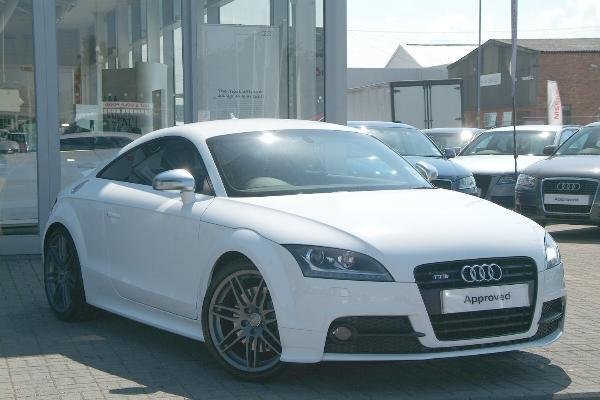

In [ ]:
from IPython.display import Image,display_jpeg
#display_jpeg(Image('cars_train/080.jpg'))
display_jpeg(Image('stanford-car/jpg/00001.jpg'))

In [ ]:
!ls -all